In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [34]:
# Load the dataset
file_path = 'cars.csv'
df = pd.read_csv(file_path)

# Initial data inspection
print("Initial DataFrame shape:", df.shape)
print(df.head())
print(df.info())

# Drop rows with missing values
df_clean = df.dropna()
print("Cleaned DataFrame shape:", df_clean.shape)

# Extract brand from name column
df_clean['name'] = df_clean['name'].apply(lambda x: x.split()[0])

# Remove extreme outliers based on Price using z-score filtering
df_clean = df_clean[(np.abs(stats.zscore(df_clean['selling_price'])) < 3)]
print("DataFrame shape after removing outliers:", df_clean.shape)


Initial DataFrame shape: (8128, 13)
                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            

C:\Users\yalts\AppData\Local\Temp\ipykernel_35764\2130856382.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['name'] = df_clean['name'].apply(lambda x: x.split()[0])


In [35]:
# Encode categorical features
df_clean = pd.get_dummies(df_clean, columns=['name'], drop_first=True)
df_clean.head()


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,...,name_Mercedes-Benz,name_Mitsubishi,name_Nissan,name_Opel,name_Renault,name_Skoda,name_Tata,name_Toyota,name_Volkswagen,name_Volvo
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,...,False,False,False,False,False,False,False,False,False,False
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,...,False,False,False,False,False,True,False,False,False,False
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,...,False,False,False,False,False,False,False,False,False,False
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,...,False,False,False,False,False,False,False,False,False,False
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,...,False,False,False,False,False,False,False,False,False,False


Mean Squared Error: 131611407015.55
R^2 Score: 0.24

5 Worst Predictions:
      Actual      Predicted         Error
0  2711000.0  602590.052506  2.108410e+06
1  2711000.0  602590.052506  2.108410e+06
2  2711000.0  602590.052506  2.108410e+06
3  2825000.0  612816.384038  2.212184e+06
4  2950000.0  626451.594837  2.323548e+06


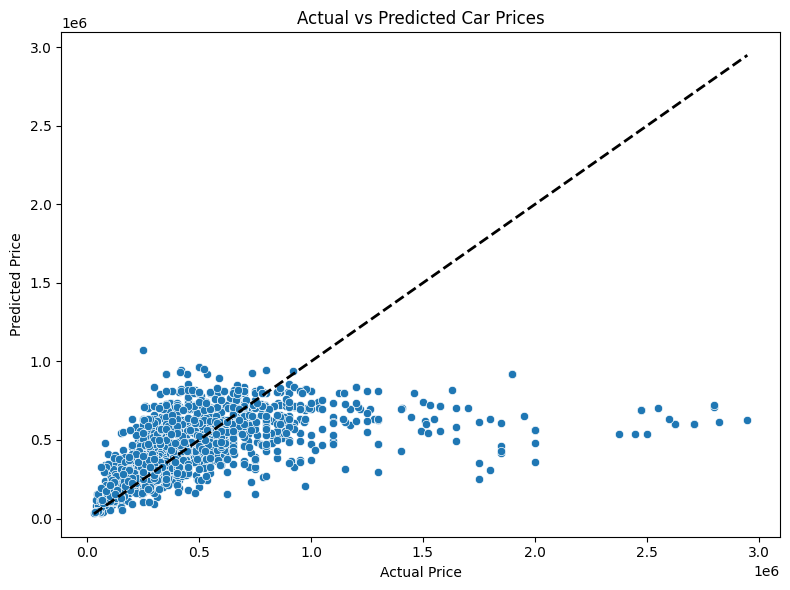


Model Coefficients:
     Feature  Coefficient
0       year     0.551332
1  km_driven     0.073788

Enter car details to get a price prediction:

Estimated Market Price: ₹130,978


In [36]:

# Select features and log-transform the target
y = np.log(df_clean['selling_price'])
features = ['year', 'km_driven'] + [col for col in df_clean.columns if col.startswith('Brand_')]
X = df_clean[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)#, random_state=42)

# Model training using Ridge regression
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predictions
log_preds = model.predict(X_test)
y_pred = np.exp(log_preds)
y_test_actual = np.exp(y_test)

# Evaluation
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Find 5 worst predictions
errors = np.abs(y_test_actual - y_pred)
worst_indices = errors.argsort()[-5:]
wrong_preds = pd.DataFrame({
    'Actual': y_test_actual.iloc[worst_indices].values,
    'Predicted': y_pred[worst_indices],
    'Error': errors.iloc[worst_indices].values
})
print("\n5 Worst Predictions:")
print(wrong_preds)

# Plotting predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# Save model coefficients for interpretation
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print("\nModel Coefficients:")
print(coef_df)

# Save to GitHub-ready format
coef_df.to_csv('model_coefficients.csv', index=False)
wrong_preds.to_csv('worst_predictions.csv', index=False)

# Predict price from user input
def predict_from_input():
    print("\nEnter car details to get a price prediction:")
    try:
        year = int(input("Year of Manufacture: "))
        mileage = float(input("Mileage (in km): "))
        brand = input("Brand (e.g., Toyota, Honda): ")

        input_dict = {
            'year': [year],
            'km_driven': [mileage]
        }

        for b in [col.replace('Brand_', '') for col in features if col.startswith('Brand_')]:
            input_dict[f'Brand_{b}'] = [1 if brand == b else 0]

        input_df = pd.DataFrame(input_dict)

        for col in features:
            if col not in input_df.columns:
                input_df[col] = 0

        input_df = input_df[features]  # Ensure column order matches training
        input_scaled = scaler.transform(input_df)
        log_price = model.predict(input_scaled)
        predicted_price = np.exp(log_price)[0]

        print(f"\nEstimated Market Price: ₹{predicted_price:,.0f}")
    except Exception as e:
        print("Error in input:", e)

# Uncomment to enable interactive prediction
predict_from_input()
